## Importing Libraries

In [43]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor

from matplotlib import pyplot as plt
%matplotlib inline

In [10]:
df = pd.read_csv('./car_fuel_efficiency.csv')
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [11]:
df.isnull().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [12]:
# fill null values with zero

df = df.fillna(0)

In [13]:
df_full_train,df_test = train_test_split(df,test_size = 0.20, random_state=1)
df_train, df_val = train_test_split(df_full_train,test_size=0.25,random_state=1)

y_full_train = df_full_train['fuel_efficiency_mpg'].values
y_test = df_test['fuel_efficiency_mpg'].values
y_train = df_train['fuel_efficiency_mpg'].values
y_val = df_val['fuel_efficiency_mpg'].values

del df_full_train['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']
del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']

df_full_train = df_full_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [15]:
full_train_dict = df_full_train.to_dict(orient='records')
test_dict = df_test.to_dict(orient='records')

train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=True)

X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

In [19]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train,y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [29]:
y_pred = dt.predict(X_val)
y_pred

array([16.88218854, 16.88218854, 16.88218854, ..., 12.9383797 ,
       12.9383797 , 16.88218854], shape=(1941,))

In [30]:
print(export_text(dt,feature_names=dv.get_feature_names_out()))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



In [33]:
rmse(y_val,y_pred)

1.6104639028827594

## Lets Train RandomForestRegressor

In [37]:
rf = RandomForestRegressor(n_estimators=10,
                           random_state=1,
                           n_jobs=-1)

In [38]:
rf.fit(X_train,y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [39]:
y_pred = rf.predict(X_val)

In [40]:
rmse(y_val,y_pred)

0.45957772230927263

## Random Forest Tuning 

In [53]:
rf_n_estimator_rmse = []
for n in range(10,201,10):
    rf = RandomForestRegressor(n_estimators=n,
                           random_state=1,
                           n_jobs=-1)
    rf.fit(X_train,y_train)
    y_pred = rf.predict(X_val)
    rmse_score = rmse(y_val,y_pred)
    rf_n_estimator_rmse.append((n,rmse_score))

df_rmse_estimator = pd.DataFrame(rf_n_estimator_rmse,columns=['n_estimators','rmse'])

    

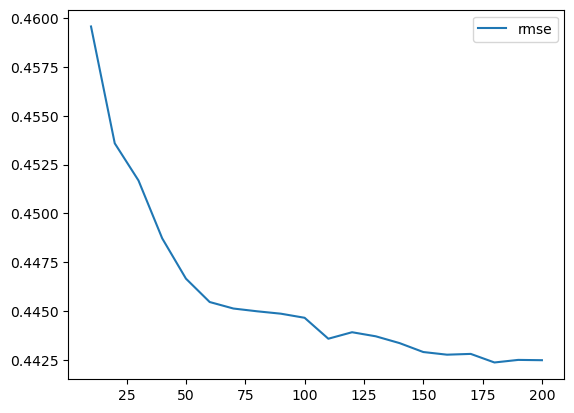

In [54]:
plt.plot(df_rmse_estimator['n_estimators'],df_rmse_estimator['rmse'],label='rmse')
plt.legend()

In [56]:
df_rmse_estimator.round(3)

,n_estimators,rmse
0,10,0.460
1,20,0.454
2,30,0.452
3,40,0.449
4,50,0.447
5,60,0.445
6,70,0.445
7,80,0.445
8,90,0.445
9,100,0.445


In [57]:
# tune for different depth 
rf_depth_estimator = []
depths = [10,15,20,25]
for d in depths:
    for n in range(10,201,10):
        rf = RandomForestRegressor(max_depth=d,
                                   n_estimators=n,
                                   random_state=1,
                                   n_jobs=-1)
        rf.fit(X_train,y_train)
        y_pred = rf.predict(X_val)
        rmse_score = rmse(y_val,y_pred)
        rf_depth_estimator.append((d,n,rmse_score))

df_depth_estimator = pd.DataFrame(rf_depth_estimator,columns=['max_depth','n_estimators','rmse'])

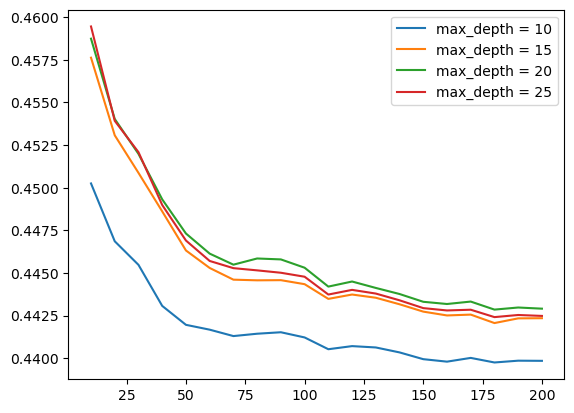

In [62]:
for d in depths:
    df_scores = df_depth_estimator[df_depth_estimator['max_depth']==d]
    plt.plot(df_scores['n_estimators'],df_scores['rmse'],label=f"max_depth = {d}")
    plt.legend()

##  Most important feature

In [65]:
rf = RandomForestRegressor(n_estimators=10,
                           max_depth=20,
                           random_state=1,
                           n_jobs=-1)

In [66]:
rf.fit(X_train,y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [77]:

df_feature_importance = pd.DataFrame({'Feature': dv.get_feature_names_out(),'Importance': rf.feature_importances_})
df_feature_importance = df_feature_importance.sort_values('Importance', ascending=False)
df_feature_importance

,Feature,Importance
13,vehicle_weight,0.959150
6,horsepower,0.015998
0,acceleration,0.011480
3,engine_displacement,0.003273
7,model_year,0.003212
8,num_cylinders,0.002343
9,num_doors,0.001635
12,origin=USA,0.000540
11,origin=Europe,0.000519
10,origin=Asia,0.000462


vehicle_weight is the most important feature